In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil

import torch
import torch.nn as nn           
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics.functional as metrics
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchviz import make_dot

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [6]:
# artist_trainDF = pd.read_csv('./DATA/wikiart_csv/artist_train.csv', header = None)
# artist_trainDF.columns = ['file location', 'code']
# artistDF_label = pd.read_csv('./DATA/wikiart_csv/artist_class.txt', sep = ' ', header = None)
# artistDF_label.columns = ['code', 'classes']

# artist_trainDF = pd.merge(artist_trainDF, artistDF_label, on = 'code')
# artist_trainDF.head()

In [7]:
# artist_trainDF.loc[0, 'file location']

In [8]:
# ROOT = './DATA/wikiart/'
# TARGET = './DATA/train/'

# def copy_image_via_category(ROOT, TARGET, df, find = 'classes'):
#     os.makedirs(TARGET, exist_ok = True)
#     for i, row in enumerate(df['file location'].values):
#     # Image.open(ROOT + df_total_weight.iloc[0]['filelocation'], 'r')
#         os.makedirs(TARGET + df.iloc[i][find], exist_ok = True)
#         shutil.copy(ROOT + row[:-4] + '_resized_resized_resized.jpg', TARGET + df.iloc[i][find] + '/')

# #copy_image_via_category(ROOT, TARGET, df_total_weight)
# copy_image_via_category(ROOT, TARGET, artist_trainDF)

In [9]:
# artist_validDF = pd.read_csv('./DATA/wikiart_csv/artist_train.csv', header = None)
# artist_validDF.columns = ['file location', 'code']
# artistDF_label = pd.read_csv('./DATA/wikiart_csv/artist_class.txt', sep = ' ', header = None)
# artistDF_label.columns = ['code', 'classes']

# artist_validDF = pd.merge(artist_validDF, artistDF_label, on = 'code')
# artist_validDF.head()

In [11]:
# ROOT = './DATA/wikiart/'
# TARGET = './DATA/valid/'

# def copy_image_via_category(ROOT, TARGET, df, find = 'classes'):
#     os.makedirs(TARGET, exist_ok = True)
#     for i, row in enumerate(df['file location'].values):
#     # Image.open(ROOT + df_total_weight.iloc[0]['filelocation'], 'r')
#         os.makedirs(TARGET + df.iloc[i][find], exist_ok = True)
#         shutil.copy(ROOT + row[:-4] + '_resized_resized_resized.jpg', TARGET + df.iloc[i][find] + '/')

# #copy_image_via_category(ROOT, TARGET, df_total_weight)
# copy_image_via_category(ROOT, TARGET, artist_validDF)

In [ ]:
# artist_validDF = pd.read_csv('./DATA/wikiart_csv/artist_valid.csv', header = None)
# artist_validDF.columns = ['file location', 'code']
# artistDF_label = pd.read_csv('./DATA/wikiart_csv/artist_class.txt', sep = ' ', header = None)
# artistDF_label.columns = ['code', 'classes']

# artist_validDF = pd.merge(artist_validDF, artistDF_label, on = 'code')
# artist_validDF.head()

In [3]:
tdata_path = './DATA/wikiart_csv/artist_train.csv'
vdata_path = './DATA/wikiart_csv/artist_valid.csv'

In [4]:
train_infoDF = pd.read_csv(tdata_path, header = None)
valid_infoDF = pd.read_csv(vdata_path, header = None)

In [5]:
train_infoDF = pd.concat([train_infoDF[0].str.split('/', expand = True), train_infoDF[1]], axis = 1)
train_infoDF.columns = ['style', 'file name', 'class']
valid_infoDF = pd.concat([valid_infoDF[0].str.split('/', expand = True), valid_infoDF[1]], axis = 1)
valid_infoDF.columns = ['style', 'file name', 'class']

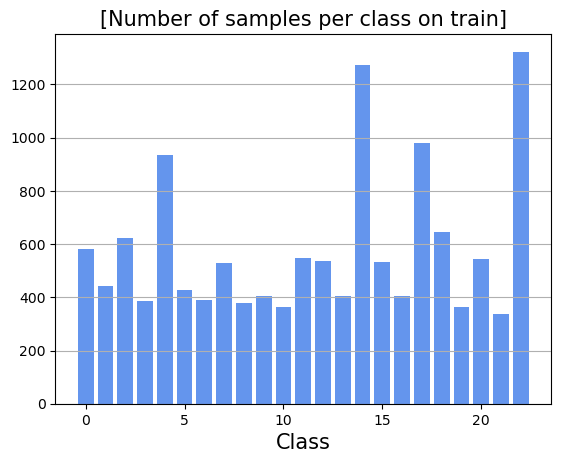

In [6]:
plt.bar(train_infoDF['class'].value_counts().index, train_infoDF['class'].value_counts().values, color = 'cornflowerblue')
plt.title('[Number of samples per class on train]', size = 15)
plt.xlabel('Class', size = 15)
plt.grid(axis ='y')
plt.show()

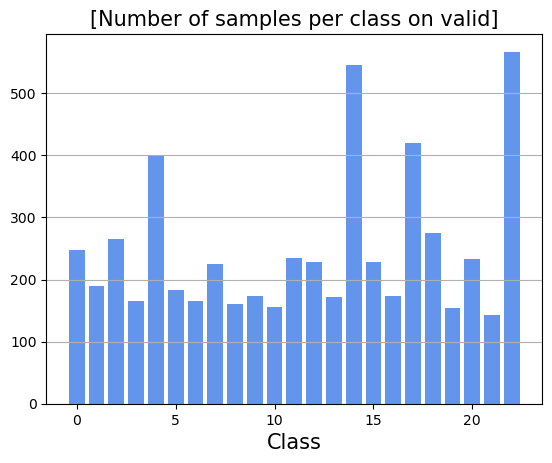

In [7]:
plt.bar(valid_infoDF['class'].value_counts().index, valid_infoDF['class'].value_counts().values, color = 'cornflowerblue')
plt.title('[Number of samples per class on valid]', size = 15)
plt.xlabel('Class', size = 15)
plt.grid(axis = 'y')
plt.show()

In [17]:
# KDH 폴더의 DATA 폴더에 있는 train 폴더로 데이터 옮기기
# my_folder = '../data/wiki_image/wikiart/'
# style_list = os.listdir(my_folder)
# for ind in range(trainDF.shape[0]):
#     for style in style_list:
#         if os.path.isdir(my_folder + style):
#             style_folder = os.listdir(my_folder + style)
#             for style_name in style_folder:
#                 if style_name == trainDF['file name'][ind]:
#                     if not os.path.exists(f"./DATA/train/{trainDF['class'][ind]}"):
#                         os.mkdir(f"./DATA/train/{trainDF['class'][ind]}")
#                     shutil.copy(os.path.join(my_folder + style, style_name), os.path.join(f"./DATA/train/{trainDF['class'][ind]}", style_name))

In [18]:
# KDH 폴더의 DATA 폴더에 있는 valid 폴더로 데이터 옮기기
# my_folder = '../data/wiki_image/wikiart/'
# style_list = os.listdir(my_folder)
# for ind in range(validDF.shape[0]):
#     for style in style_list:
#         if os.path.isdir(my_folder + style):
#             style_folder = os.listdir(my_folder + style)
#             for style_name in style_folder:
#                 if style_name == validDF['file name'][ind]:
#                     if not os.path.exists(f"./DATA/valid/{validDF['class'][ind]}"):
#                         os.mkdir(f"./DATA/valid/{validDF['class'][ind]}")
#                     shutil.copy(os.path.join(my_folder + style, style_name), os.path.join(f"./DATA/valid/{validDF['class'][ind]}", style_name))

In [8]:
# Resnet 전처리
preprocessing = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

In [9]:
train_root = './DATA/train/'
valid_root = './DATA/valid/'
trainDS = ImageFolder(root = train_root,
            transform = preprocessing)
validDS = ImageFolder(root = valid_root,
            transform = preprocessing)

In [22]:
# print(f'TrainDS => {trainDS.classes}, {trainDS.targets}, {trainDS.imgs}', sep = '\n')
# print(f'ValidDS => {validDS.classes}, {validDS.targets}, {validDS.imgs}', sep = '\n')

In [10]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


In [11]:
BATCH_SIZE = 64

In [12]:
trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE, num_workers = 8, shuffle = True, drop_last = True)
#for (img, label) in trainDL: print(img.shape, label)

In [13]:
validDL = DataLoader(validDS, batch_size = BATCH_SIZE, num_workers = 8, shuffle = False, drop_last = True)
#for (img, label) in validDL: print(img.shape, label)

In [17]:
for (img, label) in trainDL:
    print(img.shape, label)
    break

torch.Size([64, 3, 64, 64]) tensor([ 2, 22, 22,  5,  4,  5, 18,  7, 22,  1,  4, 14, 20,  1, 12,  7, 11, 18,
         7, 18, 14,  4,  7,  0, 22, 14, 18, 18,  0,  6, 13,  3,  5,  2, 11, 19,
         0,  1, 17, 14, 22, 22,  4, 12,  4,  4,  4, 22,  2,  9, 11,  4, 19, 20,
         0, 22,  5,  7, 11, 20,  2, 10, 20, 15])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

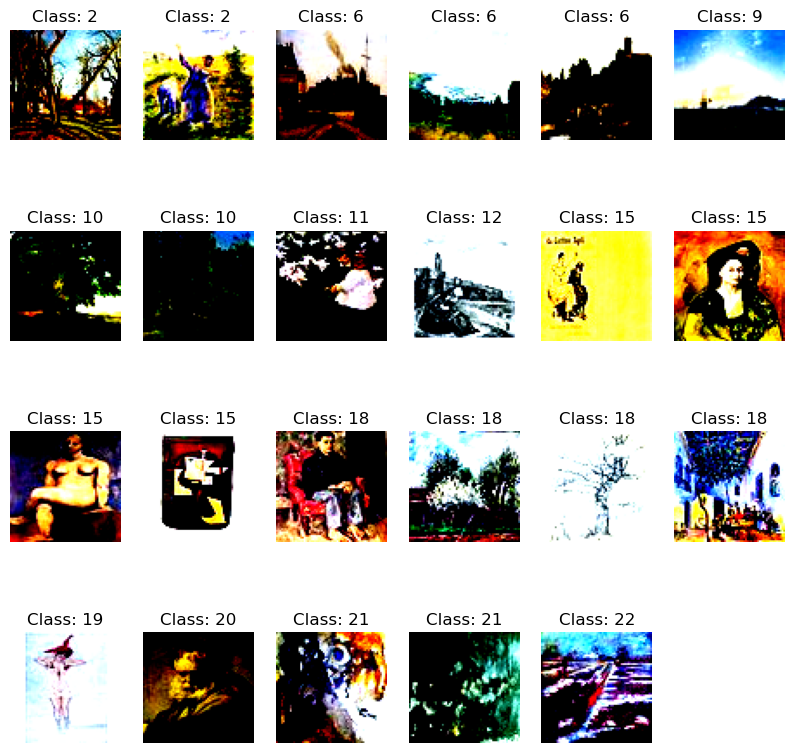

In [21]:
plt.figure(figsize=(10, 10))

for (img, label) in trainDL:
    labels = np.array([label[i].item() for i in range(23)])
    for i in np.argsort(labels):
        plt.subplot(4, 6, i + 1)
        plt.axis('off')
        plt.imshow(np.transpose(img[np.argsort(labels)[i]], (1, 2, 0)))
        plt.title('Class: ' + str(label[np.argsort(labels)[i]].item()))
    break
plt.show()

In [ ]:
plt.figure(figsize=(10, 1))

a = np.array([y_train[i].item() for i in range(10)])

for i in np.argsort(a):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[np.argsort(a)[i]], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[np.argsort(a)[i]].item()))

In [27]:
# 사전학습된 모델 인스턴스 생성
res_model = resnet18(weights = ResNet18_Weights.DEFAULT)

# 전결합층 변경
# in feature : FeatureMap에서 받은 피처 수, out_featrues : 출력/분류 클래스 수
res_model.fc = nn.Linear(in_features = 512, out_features = 23)

In [28]:
summary(model = res_model, input_size = (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 23]                  --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│

In [29]:
# Resnet18 Feature Module 파라미터 requires_grad = True => False 비활성화
for name, param in res_model.named_parameters():
    print(name, param.requires_grad, end = '     =====>     ')
    param.requires_grad = False
    print(param.requires_grad)

for name, param in res_model.fc.named_parameters():
    print(name, param.requires_grad, end = '     =====>     ')
    param.requires_grad = True
    print(param.requires_grad)

conv1.weight True     =====>     False
bn1.weight True     =====>     False
bn1.bias True     =====>     False
layer1.0.conv1.weight True     =====>     False
layer1.0.bn1.weight True     =====>     False
layer1.0.bn1.bias True     =====>     False
layer1.0.conv2.weight True     =====>     False
layer1.0.bn2.weight True     =====>     False
layer1.0.bn2.bias True     =====>     False
layer1.1.conv1.weight True     =====>     False
layer1.1.bn1.weight True     =====>     False
layer1.1.bn1.bias True     =====>     False
layer1.1.conv2.weight True     =====>     False
layer1.1.bn2.weight True     =====>     False
layer1.1.bn2.bias True     =====>     False
layer2.0.conv1.weight True     =====>     False
layer2.0.bn1.weight True     =====>     False
layer2.0.bn1.bias True     =====>     False
layer2.0.conv2.weight True     =====>     False
layer2.0.bn2.weight True     =====>     False
layer2.0.bn2.bias True     =====>     False
layer2.0.downsample.0.weight True     =====>     False
layer2

In [30]:
# 학습 준비
OPTIMIZER = optim.Adam(params = res_model.fc.parameters())
criterion = nn.CrossEntropyLoss()  # 손실 함수 정의
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)
CLASSES = 23
EPOCHS = 30

In [31]:
### ===> CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    train_loss_list = []
    train_acc_list = []
    #train_correct_list = []
    train_f1score_list = []
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        # print(output.argmax(dim = 1), label)
        # print(output.argmax(dim = 1) == label)
        loss = criterion(output, label)
        train_loss_list.append(loss.item())
        #prediction = output.max(1, keepdim = True)[1]
        #correct = prediction.eq(label.view_as(prediction)).sum().item()
        #train_correct_list.append(correct)
        train_accuracy = metrics.accuracy(output, label, task = 'multiclass', num_classes = CLASSES).item()
        train_acc_list.append(train_accuracy)
        train_f1_score = metrics.f1_score(output, label, task = 'multiclass', num_classes = CLASSES).item()
        train_f1score_list.append(train_f1_score)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")
    
    train_loss = sum(train_loss_list) / len(train_loader)
    #train_loss = np.mean(train_loss_list)
    train_accuracy = sum(train_acc_list) / len(train_loader)
    #train_accuracy = metrics.accuracy(output, label, task = 'multiclass', num_classes = CLASSES)
    #train_f1_score = sum(train_f1score_list) / len(train_loader.dataset)
    train_f1_score = sum(train_f1score_list) / len(train_loader)
    return train_loss, train_accuracy, train_f1_score   

In [32]:
### ===> 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, val_loader):
    model.eval()
    #test_loss = 0
    #correct = 0
    #test_f1_score = 0
    val_loss_list = []
    val_acc_list = []
    val_f1score_list = []
    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            val_loss = criterion(output, label).item()
            val_loss_list.append(val_loss)
            #test_loss += criterion(output, label).item()
            #prediction = output.max(1, keepdim = True)[1]
            #correct += prediction.eq(label.view_as(prediction)).sum().item()
            val_accuracy = metrics.accuracy(output, label, task = 'multiclass', num_classes = CLASSES).item()
            val_acc_list.append(val_accuracy)
            val_f1_score = metrics.f1_score(output, label, task = 'multiclass', num_classes = CLASSES).item()
            val_f1score_list.append(val_f1_score)
            #test_f1_score += metrics.f1_score(output, label, task='multiclass', num_classes = CLASSES).item()
            #test_list.append(metrics.accuracy(output, label, task='multiclass', num_classes = CLASSES))
          
    val_loss = sum(val_loss_list) / len(val_loader)
    val_accuracy = sum(val_acc_list) / len(val_loader)
    #test_accuracy = np.mean(test_list)
    val_f1_score = sum(val_f1score_list) / len(val_loader)
    return val_loss, val_accuracy, val_f1_score

In [33]:
loss_list = [[], []]
acc_list = [[], []]
f1_list = [[], []]
for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_accuracy, train_f1_score = train(epoch, res_model, trainDL, OPTIMIZER, log_interval = 200)
    val_loss, val_accuracy, val_f1_score = evaluate(res_model, validDL)
    
    print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tTrain F1 score : {train_f1_score}\n")
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {val_loss:.4f}, \tTest Accuracy: {val_accuracy:.2f} % \tTest F1 score :{val_f1_score}\n")

    SCHEDULER.step(val_loss)
    # 조기종료 기능 => 조건 : test_loss가 지정된 횟수이상 개선이 안되면 학습 종료
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        print(f'Early stopping at epoch {epoch}')
        break

    loss_list[0].append(train_loss)
    loss_list[1].append(val_loss)
    acc_list[0].append(train_accuracy)
    acc_list[1].append(val_accuracy)
    f1_list[0].append(train_f1_score)
    f1_list[1].append(val_f1_score)

Train Epoch: 1 [0]	Train Loss: 3.617958
Train Epoch: 1 [200]	Train Loss: 2.200167

[EPOCH: 1], 	Train Loss: 2.4853, 	Train Accuracy: 0.29 %, 	Train F1 score : 0.2902644230769231


[EPOCH: 1], 	Test Loss: 2.1512, 	Test Accuracy: 0.38 % 	Test F1 score :0.3843047752808989

Train Epoch: 2 [0]	Train Loss: 1.751125
Train Epoch: 2 [200]	Train Loss: 1.831854

[EPOCH: 2], 	Train Loss: 2.0088, 	Train Accuracy: 0.41 %, 	Train F1 score : 0.4142878605769231


[EPOCH: 2], 	Test Loss: 2.0623, 	Test Accuracy: 0.41 % 	Test F1 score :0.40923455056179775

Train Epoch: 3 [0]	Train Loss: 1.870767
Train Epoch: 3 [200]	Train Loss: 1.996195

[EPOCH: 3], 	Train Loss: 1.8989, 	Train Accuracy: 0.44 %, 	Train F1 score : 0.44088040865384615


[EPOCH: 3], 	Test Loss: 2.0369, 	Test Accuracy: 0.42 % 	Test F1 score :0.4180126404494382

Train Epoch: 4 [0]	Train Loss: 1.859979
Train Epoch: 4 [200]	Train Loss: 2.006286

[EPOCH: 4], 	Train Loss: 1.8371, 	Train Accuracy: 0.46 %, 	Train F1 score : 0.458984375


[EPOCH: 4], 

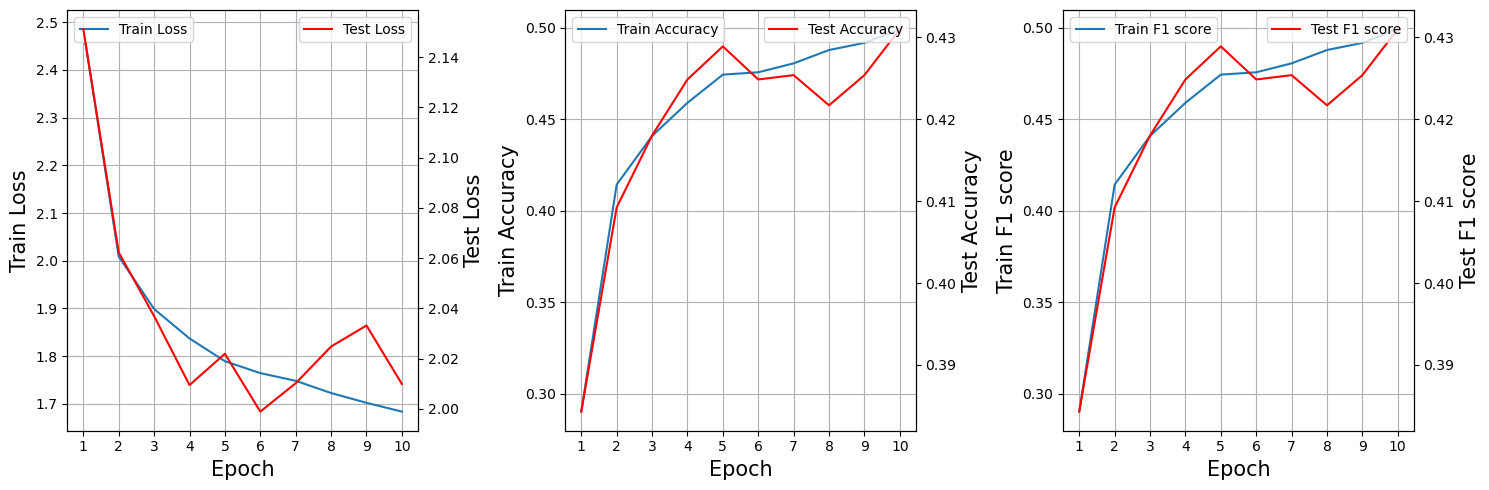

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(loss_list[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Epoch", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(EPOCHS))
axes[0].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list[1], label = "Test Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test Loss", size = 15)

axes[1].plot(acc_list[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Epoch", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(EPOCHS))
axes[1].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list[1], label = "Test Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test Accuracy", size = 15)

axes[2].plot(f1_list[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Epoch", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(EPOCHS))
axes[2].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_list[1], label = "Test F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test F1 score", size = 15)
plt.tight_layout()
plt.show()